# Lab 6: Non-linear function approximation

## Exercise 1: Q-Learning with a Neural Network (PyTorch) on MountainCar

**Objective:**
Implement **Q-learning** with a **PyTorch neural network** to solve `MountainCar-v0`. You will approximate Q(s, a) with a small MLP, train it from batches of transitions sampled from a replay buffer, and evaluate the learned policy.

---

## Environment
- **Gym** environment: `MountainCar-v0`
- **State**: continuous (position, velocity) → shape `(2,)`
- **Actions**: {0: left, 1: no push, 2: right}
- **Reward**: -1 per step until the goal (`position >= 0.5`)
- **Episode limit**: 500 steps
- **Goal**: reduce steps-to-goal and improve return over training

---

## What You Must Implement

### 1) Q-Network (PyTorch)
Create a small MLP `QNetwork` that maps `state -> Q-values for 3 actions`.
- Inputs: `(batch_size, 2)` float32
- Outputs: `(batch_size, 3)` Q-values
- Suggested architecture: `2 → 64 → 3` with ReLU
- Initialize weights reasonably (PyTorch defaults are fine)

### 2) Replay Buffer
A cyclic buffer to store transitions `(s, a, r, s_next, done)`:
- `append(s, a, r, s_next, done)`
- `sample(batch_size)` → tensors ready for PyTorch (float32 for states, int64 for actions, float32 for rewards/done)

### 3) ε-Greedy Policy
- With probability `epsilon`: pick a random action
- Otherwise: `argmax_a Q(s, a)` from the current network
- Use **decaying ε** (e.g., from 1.0 down to 0.05 over ~20–50k steps)

### 4) Q-Learning Target and Loss
For a sampled batch:
- Compute `q_pred = Q(s).gather(1, a)`  (shape `(batch, 1)`)
- Compute target:
  - If `done`: `target = r`
  - Else: `target = r + gamma * max_a' Q(s_next, a').detach()`
- Loss: Mean Squared Error (MSE) between `q_pred` and `target`

> **Stabilization (recommended)**: Use a **target network** `Q_target` (periodically copy weights from `Q_online`) to compute the max over next-state actions. Update every `target_update_freq` steps.

### 5) Deep Q-learning method
- For each environment step:
  1. Select action with ε-greedy
  2. Step the env, store transition in buffer
  3. If `len(buffer) >= batch_size`:
     - Sample a batch
     - Compute `q_pred`, `target`
     - Backprop: `optimizer.zero_grad(); loss.backward(); optimizer.step()`
     - (Optional) gradient clipping (e.g., `clip_grad_norm_` at 10)
  4. Periodically update `Q_target ← Q_online` (if using target net)
- Track episode returns (sum of rewards) and steps-to-goal

---

## Evaluation
- Run **evaluation episodes** with `epsilon = 0.0` (greedy) every N training episodes
- Report:
  - Average steps-to-goal (lower is better; random policy is ~200)
  - Average return (less negative is better)
- Plot:
  - Training episode return

---

## Deliverables
1. **Code**: In a notebook.
2. **Plots**:
   - Episode  vs return
   - Final value function (State (postition and velocity) Vs Max(Q(state)))

3. **Short write-up** (also in the notebook):
   - **Performance of your DQN agent**: How quickly does it learn? Does it reach the goal consistently?
   - **Comparison with tile coding**:
     - Which representation learns faster?
     - Which one is more stable?
     - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
     - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
   - **Insights**: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?



In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up environment
env = gym.make("MountainCar-v0")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
gamma = 0.99
alpha = 0.001
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 5000
batch_size = 64
replay_buffer_size = 50000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [4]:
# Initialize Q-network and optimizer
q_net = QNetwork(state_dim, n_actions).to(device)

target_net = QNetwork(state_dim, n_actions).to(device)
target_net.load_state_dict(q_net.state_dict())

optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

In [5]:
def epsilon_greedy(state, epsilon, n_actions):

  if np.random.rand() < epsilon:
      return np.random.choice(n_actions)

  q_net.eval() # Good practice: set network to evaluation mode for inference
  with torch.no_grad():
      state_tensor = torch.FloatTensor(state).to(device).unsqueeze(0)
      action = q_net(state_tensor).argmax().item()
  q_net.train() # Set it back to train mode
  return action

In [6]:
def train_dqn():
    """Train the DQN using experience replay."""
    if len(replay_buffer) < batch_size:
        return
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    with torch.no_grad():
        next_q_values = target_net(next_states).max(1)[0]

    targets = rewards + gamma * next_q_values * (1 - dones)

    loss = loss_fn(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(q_net.parameters(), max_norm=1.0) # Clip gradients
    optimizer.step()

In [ ]:
## MAIN Loop ##
rewards_dqn = []
total_steps = 0
TARGET_UPDATE_FREQ = 500 
TRAIN_EVERY_N_STEPS = 4


for episode in range(num_episodes):
  if episode % 100 == 0 and episode > 0:
     print(f"Episode {episode}, Epsilon: {epsilon:.3f}")
  state = env.reset()[0]
  total_reward = 0
  done = False

  while not done:
    total_steps += 1
    action = epsilon_greedy(state, epsilon, 3)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    replay_buffer.append((state, action, reward, next_state, done))
    state = next_state
    total_reward += reward

    if total_steps % TRAIN_EVERY_N_STEPS == 0:
        train_dqn()

    if total_steps % TARGET_UPDATE_FREQ == 0:
        target_net.load_state_dict(q_net.state_dict())

  rewards_dqn.append(total_reward)
  epsilon = max(epsilon * epsilon_decay, epsilon_min)

/var/folders/g1/jhxgg6j14z55wpg1cngfhx900000gn/T/ipykernel_5119/1505363312.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  states = torch.FloatTensor(states).to(device)


Episode 100, Epsilon: 0.606
Episode 200, Epsilon: 0.367
Episode 300, Epsilon: 0.222
Episode 400, Epsilon: 0.135
Episode 500, Epsilon: 0.082
Episode 600, Epsilon: 0.049
Episode 700, Epsilon: 0.030
Episode 800, Epsilon: 0.018
Episode 900, Epsilon: 0.011
Episode 1000, Epsilon: 0.010
Episode 1100, Epsilon: 0.010
Episode 1200, Epsilon: 0.010
Episode 1300, Epsilon: 0.010
Episode 1400, Epsilon: 0.010
Episode 1500, Epsilon: 0.010
Episode 1600, Epsilon: 0.010
Episode 1700, Epsilon: 0.010
Episode 1800, Epsilon: 0.010
Episode 1900, Epsilon: 0.010
Episode 2000, Epsilon: 0.010
Episode 2100, Epsilon: 0.010
Episode 2200, Epsilon: 0.010
Episode 2300, Epsilon: 0.010
Episode 2400, Epsilon: 0.010
Episode 2500, Epsilon: 0.010
Episode 2600, Epsilon: 0.010
Episode 2700, Epsilon: 0.010
Episode 2800, Epsilon: 0.010
Episode 2900, Epsilon: 0.010
Episode 3000, Epsilon: 0.010
Episode 3100, Epsilon: 0.010
Episode 3200, Epsilon: 0.010
Episode 3300, Epsilon: 0.010
Episode 3400, Epsilon: 0.010
Episode 3500, Epsilon: 

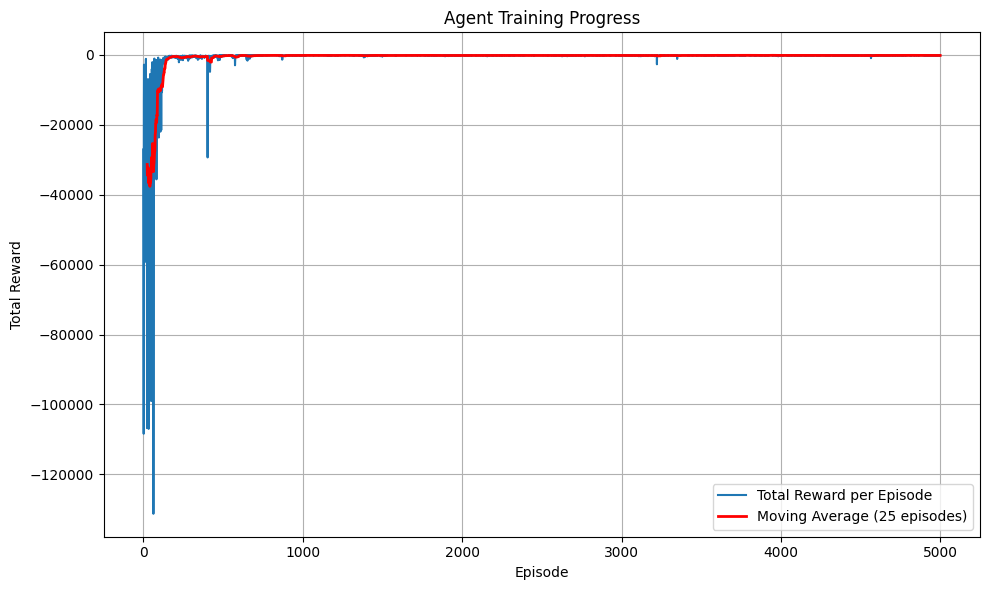

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(rewards_dqn, label='Total Reward per Episode')

# Calculating and plotting a moving average to see the trend
window_size = 25
if len(rewards_dqn) >= window_size:
    moving_average = np.convolve(rewards_dqn, np.ones(window_size)/window_size, mode='valid')
    plt.plot(np.arange(window_size - 1, len(rewards_dqn)), moving_average, color='red', linewidth=2, label=f'Moving Average ({window_size} episodes)')

plt.title('Agent Training Progress')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot to a file
plt.savefig('reward_plot.png')

# Exercise 2: Deep Q-Learning (DQN) on LunarLander-v2

## Problem Description
In this exercise, you will implement **Deep Q-Learning (DQN)** to solve the classic control problem **LunarLander-v2** in Gym.

### The Task
The agent controls a lander that starts at the top of the screen and must safely land on the landing pad between two flags.

- **State space**: Continuous vector of 8 variables, including:
  - Position (x, y)
  - Velocity (x_dot, y_dot)
  - Angle and angular velocity
  - Left/right leg contact indicators
- **Action space**: Discrete, 4 actions
  - 0: do nothing
  - 1: fire left orientation engine
  - 2: fire main engine
  - 3: fire right orientation engine
- **Rewards**:
  - +100 to +140 for successful landing
  - -100 for crashing
  - Small negative reward for firing engines (fuel cost)
  - Episode ends when lander crashes or comes to rest

The goal is to train an agent that lands successfully **most of the time**.

---

## Algorithm: Deep Q-Learning
You will implement a **DQN agent** with the following components:

1. **Q-Network**
   - Neural network that approximates Q(s, a).
   - Input: state vector (8 floats).
   - Output: Q-values for 4 actions.
   - Suggested architecture: 2 hidden layers with 128 neurons each, ReLU activation.

2. **Target Network**
   - A copy of the Q-network that is updated less frequently (e.g., every 1000 steps).
   - Used for stable target computation.

3. **Replay Buffer**
   - Stores transitions `(s, a, r, s_next, done)`.
   - Sample random mini-batches to break correlation between consecutive samples.

4. **ε-Greedy Policy**
   - With probability ε, take a random action.
   - Otherwise, take `argmax_a Q(s, a)`.
   - Decay ε over time (e.g., from 1.0 → 0.05).

5. **Q-Learning Method**
   


**Final note:**
   No code base is necessary. At this point, you must know how to implement evertything.
   For reference, but not recommended ([Here](https://colab.research.google.com/drive/1Gl0kuln79A__hgf2a-_-mwoGISXQDK_X?authuser=1#scrollTo=8Sd0q9DG8Rt8&line=56&uniqifier=1) is a solution)

---
## Deliverables
1. **Code**:
- Q-network (PyTorch).
- Training loop with ε-greedy policy, target network, and Adam optimizer.

2. **Plots**:
- Episode returns vs training episodes.
- Evaluation performance with a greedy policy (ε = 0).

3. **Short Write-up (≤1 page)**:
- Did your agent learn to land consistently?  
- How many episodes did it take before you saw improvement?  
- What effect did replay buffer size, target update frequency, and learning rate have on stability?  
- Compare results across different runs (does it sometimes fail to converge?).

Compare this task with the **MountainCar-v0** problem you solved earlier:
- What is **extra** or more challenging in LunarLander?  
- Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.  
- Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?


In [3]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim

# --- Environment ---
env = gym.make("LunarLander-v3")
state_dim = env.observation_space.shape[0]  # Should be 8
n_actions = env.action_space.n          # Should be 4

# --- Q-Network ---
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        return self.network(x)

In [4]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# --- Environment Setup ---
# Using the new "terminated", "truncated" return format
env = gym.make("LunarLander-v3")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# --- Hyperparameters ---
gamma = 0.99
alpha = 5e-4  # Learning rate, often smaller for more complex problems
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 2000
batch_size = 64
replay_buffer_size = 100000 # Larger buffer for more diverse experience

# --- Training Control ---
TARGET_UPDATE_FREQ = 1000 # Update target network every 1000 steps
TRAIN_EVERY_N_STEPS = 4   # Train the agent every 4 steps
EVAL_EVERY_N_EPISODES = 50 # Evaluate the agent's greedy performance periodically

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [5]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        # As per the exercise description: 2 hidden layers with 128 neurons
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [6]:
q_net = QNetwork(state_dim, n_actions).to(device)
target_net = QNetwork(state_dim, n_actions).to(device)
target_net.load_state_dict(q_net.state_dict()) # Sync networks at the start

optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

In [7]:
def epsilon_greedy(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(n_actions)

    q_net.eval()
    with torch.no_grad():
        state_tensor = torch.FloatTensor(state).to(device).unsqueeze(0)
        action = q_net(state_tensor).argmax().item()
    q_net.train()
    return action

In [8]:
def train_dqn():
    if len(replay_buffer) < batch_size:
        return
    
    batch = random.sample(replay_buffer, batch_size)
    # Using np.vstack for states and next_states is more robust
    states = np.vstack([t[0] for t in batch])
    actions = np.array([t[1] for t in batch])
    rewards = np.array([t[2] for t in batch])
    next_states = np.vstack([t[3] for t in batch])
    dones = np.array([t[4] for t in batch])

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    # Get Q-values for actions taken
    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    # Get max Q-values for next states from the target network
    with torch.no_grad():
        next_q_values = target_net(next_states).max(1)[0]

    # Compute the target Q-values
    targets = rewards + gamma * next_q_values * (1 - dones)

    # Update the Q-network
    loss = loss_fn(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(q_net.parameters(), max_norm=1.0)
    optimizer.step()


In [9]:
def evaluate_agent(n_eval_episodes=10):
    """Runs the agent with a greedy policy for a number of episodes."""
    total_rewards = []
    for _ in range(n_eval_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = epsilon_greedy(state, epsilon=0.0) # Always greedy
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state
        total_rewards.append(episode_reward)
    return np.mean(total_rewards)

In [10]:
training_rewards = []
evaluation_rewards = []
total_steps = 0

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        total_steps += 1
        action = epsilon_greedy(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        # Train the network at a fixed frequency
        if total_steps % TRAIN_EVERY_N_STEPS == 0:
            train_dqn()

        # Update the target network at a fixed frequency
        if total_steps % TARGET_UPDATE_FREQ == 0:
            # print(f"  --> Step {total_steps}: Updating target network...")
            target_net.load_state_dict(q_net.state_dict())

    training_rewards.append(total_reward)
    
    # Decay epsilon after each episode
    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    
    # --- Periodic Evaluation ---
    if (episode + 1) % EVAL_EVERY_N_EPISODES == 0:
        avg_eval_reward = evaluate_agent()
        evaluation_rewards.append(avg_eval_reward)
        print(f"Episode {episode+1}/{num_episodes} | Epsilon: {epsilon:.3f} | Avg Training Reward: {np.mean(training_rewards[-100:]):.2f} | Avg Eval Reward: {avg_eval_reward:.2f}")


Episode 50/2000 | Epsilon: 0.778 | Avg Training Reward: -146.81 | Avg Eval Reward: -149.59
Episode 100/2000 | Epsilon: 0.606 | Avg Training Reward: -128.35 | Avg Eval Reward: -203.04
Episode 150/2000 | Epsilon: 0.471 | Avg Training Reward: -93.33 | Avg Eval Reward: -58.91
Episode 200/2000 | Epsilon: 0.367 | Avg Training Reward: -63.38 | Avg Eval Reward: -80.61
Episode 250/2000 | Epsilon: 0.286 | Avg Training Reward: -37.06 | Avg Eval Reward: -33.89
Episode 300/2000 | Epsilon: 0.222 | Avg Training Reward: 4.98 | Avg Eval Reward: 165.74
Episode 350/2000 | Epsilon: 0.173 | Avg Training Reward: 99.98 | Avg Eval Reward: 26.89
Episode 400/2000 | Epsilon: 0.135 | Avg Training Reward: 163.31 | Avg Eval Reward: 147.67
Episode 450/2000 | Epsilon: 0.105 | Avg Training Reward: 187.42 | Avg Eval Reward: 103.35
Episode 500/2000 | Epsilon: 0.082 | Avg Training Reward: 228.61 | Avg Eval Reward: 238.34
Episode 550/2000 | Epsilon: 0.063 | Avg Training Reward: 240.63 | Avg Eval Reward: 254.71
Episode 600

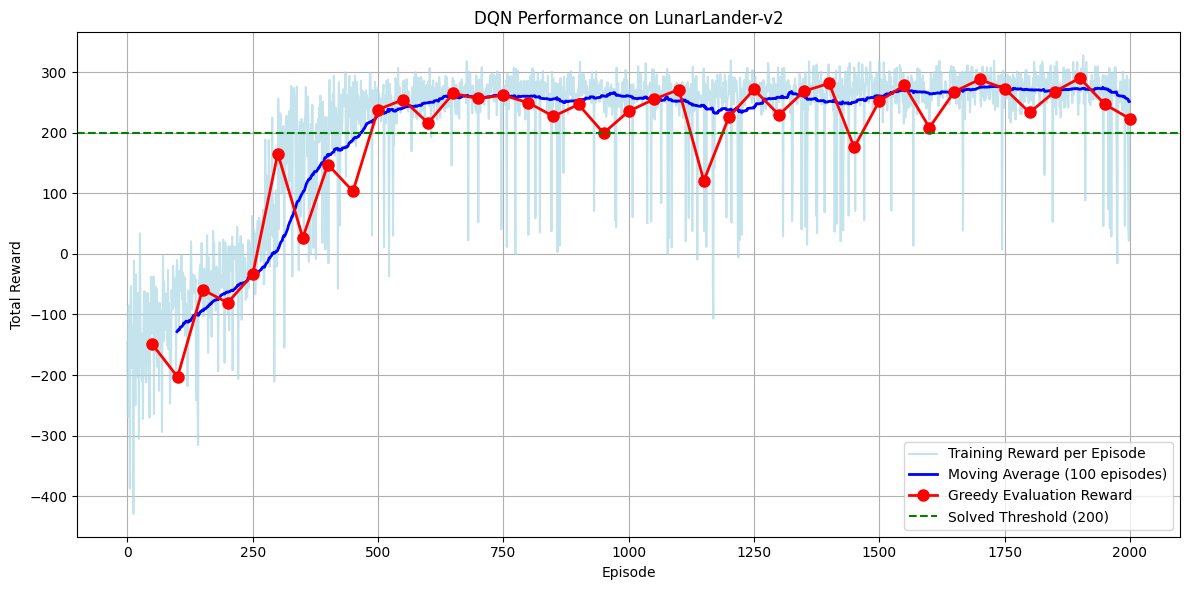

In [11]:
plt.figure(figsize=(12, 6))

# Plot training rewards and a moving average
plt.plot(training_rewards, label='Training Reward per Episode', color='lightblue', alpha=0.7)
window_size = 100
moving_average = np.convolve(training_rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(np.arange(window_size - 1, len(training_rewards)), moving_average, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')

# Plot evaluation rewards
eval_episodes_x_axis = [(i + 1) * EVAL_EVERY_N_EPISODES for i in range(len(evaluation_rewards))]
plt.plot(eval_episodes_x_axis, evaluation_rewards, 'o-', color='red', linewidth=2, markersize=8, label='Greedy Evaluation Reward')


plt.axhline(y=200, color='green', linestyle='--', label='Solved Threshold (200)')
plt.title('DQN Performance on LunarLander-v2')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

env.close()